Задача 03:
Построить классификатор на основе конволюционной нейросети на данных MNIST, включающий:
- аугментацию исходных данных
- конволюции
- пулинг
- батчнорм
- дропаут
- сокращение шага обучения
- автоматическую остановку обучения.

Базовый пример работы с MNIST - https://github.com/analysiscenter/dataset/blob/master/examples/opensets/mnist_model.py

Примеры аугментаций можно посмотреть в https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py.

Если вам нужны другие способы аугментации изображений, смело добавляйте их к своему батч-классу.

Срок - среда, 02.08, 16:00.
Это окончательный неизменяемый срок. В этот срок заказчик должен получить готовую полностью удовлетворяющую его работу, а не кучу непонятных файлов непонятного качества.
А в 16:01 вы уже начнете работу над следующей задачей, и к задаче 03 больше возвратов не будет.
Так что нужно работать динамично, постоянно коммуницируя с заказчиком, чтобы он получил ровно то, что ему нужно, а не что попало.

In [1]:
import os
import blosc

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook as tqn
from matplotlib import pyplot as plt
%matplotlib inline

from MnistBatch import MnistBatch
from dataset import Dataset, DatasetIndex


### Create dataset and split it on train / tast / validation samples.

In [29]:
ix = DatasetIndex(range(65000))
mnist = Dataset(ix, batch_class=MnistBatch)
mnist.cv_split([0.8, 0.1, 0.1])

### Create tensorflow session

In [30]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### let's write pipline for train

In [32]:
train_loss = []
train_pipeline = (mnist.train.
                  p.
                  load(src='./../MNIST_data', fmt='blosc').
                  random_rotate(p=1, angle=(-30, 30), preserve_shape=True). #random rotate with angle 
                                                                              # from -30 degrees to 30 degrees
                  random_scale(p=1, factor=(.8, 1.2)). # Resizing from 100% to random in (80% - 120%)
                  train_conv(sess, train_loss))

### And test

In [33]:
stats = []
test_pipeline = (mnist.test.
                 p.
                 load(src='./../MNIST_data', fmt='blosc').
                 random_rotate(p=1, angle=(-30, 30), preserve_shape=True). # Random rotate with angle 
                                                                            # from -30 degrees to 30 degrees
                 random_scale(p=1, factor=(.8, 1.2)). # Resizing from 100% to random in (80% - 120%)
                 update_stats(sess, stats))

### Training model and calcualte accuracy on test sample

In [42]:
MAX_ITER = 800
window = 50
average = [0]
for curr_iter in tqn(range(1, MAX_ITER + 1)):
    #training model
    train_pipeline.next_batch(100, n_epochs=None)
    
    #testing model and calculate accuracy
    test_pipeline.next_batch(100, n_epochs=None)
    
    #Early stopping
    if curr_iter % window == 0:
        average.append(np.mean(stats[curr_iter - window:]))
        
    if average[-1] > 0.99:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

### Let's testing our model!

### Create new pipeline for predict.

In [46]:
dict_pred = {'imgs': [], 'predict': [], 'answer': []}
pred_pipeline = (mnist.validation.
                p.
                load(src='./../MNIST_data', fmt='blosc'). 
                random_rotate(p=1, angle=(-30, 30), preserve_shape=True).
                random_scale(p=1, factor=(.8, 1.2)).
                prediction(sess, dict_pred))

(1, 28, 28)


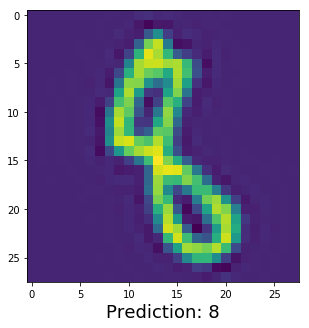

(1, 28, 28)


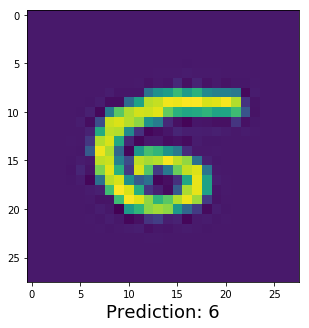

(1, 28, 28)


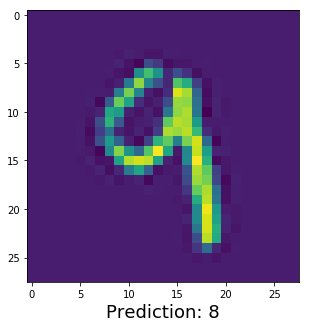

(1, 28, 28)


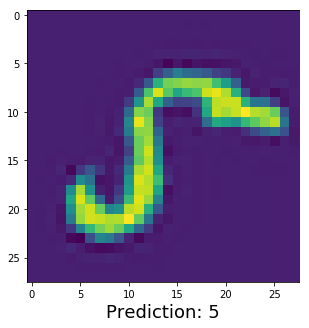

(1, 28, 28)


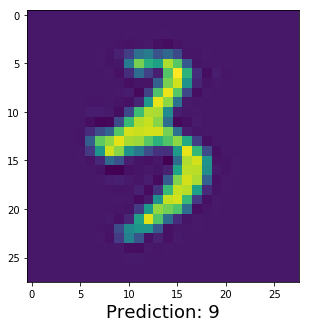

(1, 28, 28)


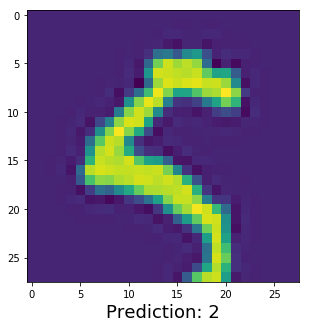

(1, 28, 28)


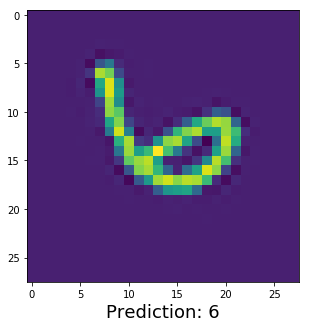

(1, 28, 28)


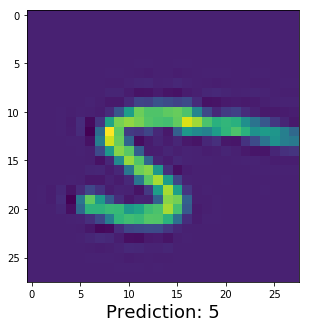

(1, 28, 28)


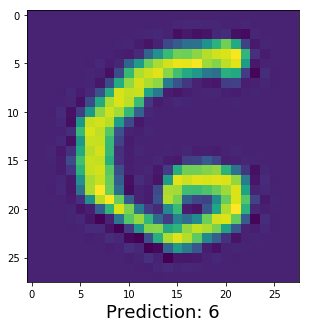

(1, 28, 28)


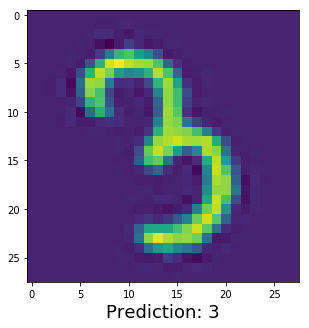

In [50]:
for num_batch in range(10):
    pred_pipeline.next_batch(1, shuffle=True)
    plt.figure(figsize=(5,5))
    plt.imshow(dict_pred['imgs'][-1].reshape(-1, 28))
    plt.xlabel('Prediction: {}'.format(np.argmax(dict_pred['predict'][-1])), fontsize=18)
    plt.show()